In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

In [2]:
!pwd

/home/dsc/TFM/repositorio


In [3]:
data_root = "/home/dsc/TFM/repositorio/"

In [4]:
columns = ['user_id', 'rating', 'comida', 'id_comida' ]
datafile = os.path.join(data_root, "Encuesta_vf.csv")
data = pd.read_csv(datafile, sep=';', header =0, names=columns, encoding='latin-1')
data.head()

,user_id,rating,comida,id_comida
0,18,3,Ensalada de col con queso,4
1,33,1,Ensalada de col con queso,4
2,63,1,Ensalada de col con queso,4
3,64,2,Ensalada de col con queso,4
4,65,1,Ensalada de col con queso,4


In [5]:
n_users = data.user_id.unique().shape[0]
n_items = data.comida.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

1084 users
407 items


In [6]:
items_id = {}
food = data.comida.unique()
food_id = {}
n = 0
for x in food:
    items_id[x] = n
    food_id[n] = x
    n += 1

In [7]:
items_id['Puchero casero']

110

In [8]:
index = list(range(len(data.index)))

In [9]:
column_items_id=[]
for x in index:
    column_items_id.append(items_id[data['comida'][x]]) 

In [10]:
data['items_id'] = column_items_id

In [11]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [12]:
p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
data = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  28943
Ejemplos usados para test:  12571


In [13]:
ratings = np.zeros((n_users, n_items))
n_rating = len(train) + len(test)
sparsity = n_rating/(ratings.shape[0] * ratings.shape[1])
sparsity *=100
print (sparsity)

9.40959409594096


In [14]:
train.head()

,user_id,rating,comida,id_comida,items_id,is_train
0,18,3,Ensalada de col con queso,4,0,True
1,33,1,Ensalada de col con queso,4,0,True
2,63,1,Ensalada de col con queso,4,0,True
3,64,2,Ensalada de col con queso,4,0,True
4,65,1,Ensalada de col con queso,4,0,True


In [15]:
data_top=(data[data.rating>2])

In [16]:
data_untop=(data[data.rating<=2])

In [17]:
foodPerUser1 = (data_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [18]:
# Matriz de coocurrencia de los que le gustan
coMatrix_top = np.zeros((n_items, n_items))
for food in foodPerUser1.values():
    for x in food:
        coMatrix_top[x, food] += 1

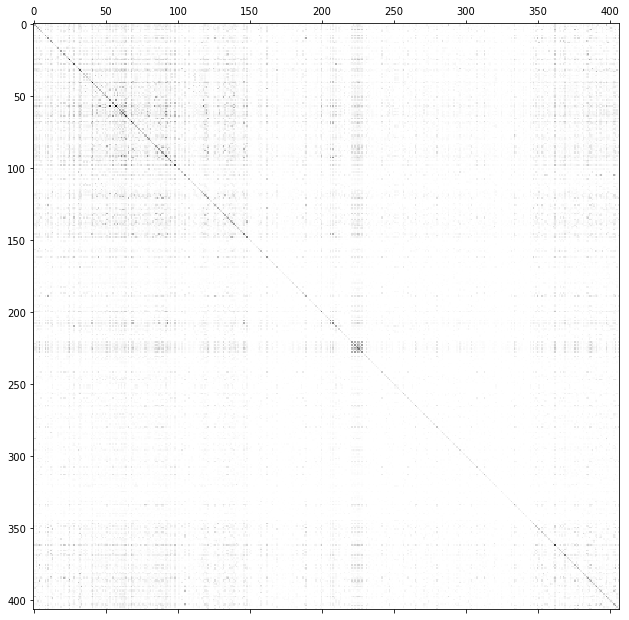

In [19]:
plt.matshow(coMatrix_top, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [20]:
foodPerUser2 = (data_untop.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [21]:
# # Matriz de coocurrencia de los que NO le gustan
coMatrix2 = np.zeros((n_items, n_items))
for food in foodPerUser2.values():
    for x in food:
        coMatrix2[x, food] += 1

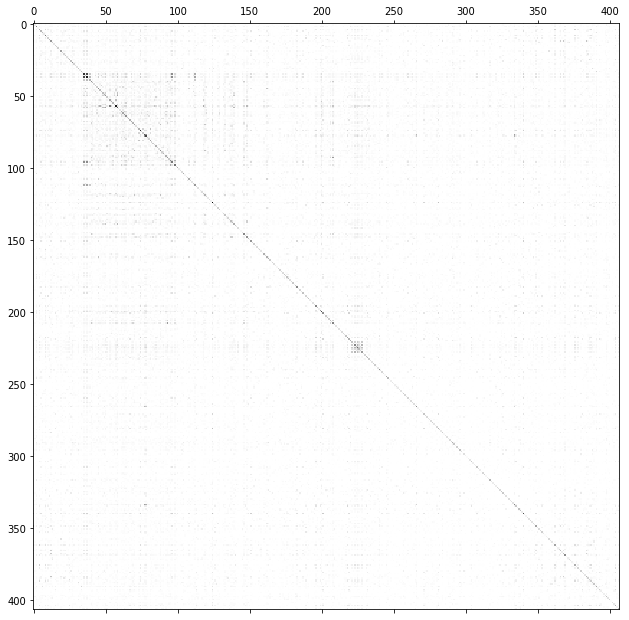

In [22]:
plt.matshow(coMatrix2, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#Ntop similarity

In [23]:
train_top=(train[train.rating>2])

In [24]:
foodPerUser = (train_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [25]:
coMatrix_top_train = np.zeros((n_items, n_items))
for food in foodPerUser.values():
    for x in food:
        coMatrix_top_train[x, food] += 1

In [26]:
coMatrix_top_train

array([[113.,  12.,   9., ...,  12.,   9.,   0.],
       [ 12.,  79.,   5., ...,   2.,   1.,   0.],
       [  9.,   5., 114., ...,   3.,   0.,   0.],
       ...,
       [ 12.,   2.,   3., ..., 101.,   3.,  15.],
       [  9.,   1.,   0., ...,   3.,  39.,   2.],
       [  0.,   0.,   0., ...,  15.,   2.,  46.]])

In [27]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Retorna los ntop más similares según la matriz coocurrencia
    """
    similarItems = coocurrance[item_id, :]
    mostSimilar = np.argsort(similarItems)[::-1]
    mostSimilar = mostSimilar[1:ntop+1]
    

    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [28]:
co_occurrance_similarity(122, coMatrix_top_train, 10)

array([[ 31.,  16.],
       [ 62.,  13.],
       [125.,  12.],
       [ 61.,  10.],
       [129.,   9.],
       [ 92.,   8.],
       [223.,   8.],
       [ 63.,   8.],
       [ 25.,   8.],
       [103.,   7.]])

In [29]:
column_items_id[122]

0

In [30]:
FoodId = 1
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (food_id[FoodId], Ntop))

similarItems = co_occurrance_similarity(FoodId, coMatrix_top_train, Ntop)

for r in similarItems:
    print(int(r[0]), food_id[int(r[0])], r[1])

For item "Ensalada de tomate y pimiento asado" top-5 recommendations are:
398 Tortilla de Pimientos y Cebolla 42.0
288 Canelones con Verduras 25.0
57 Chuletas de cerdo con salsa mostaza 23.0
200 Empanadas argentinas 20.0
225 Merluza rebozada 20.0


In [31]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Devuelve la lista ntop recomendacciones, en base a un items_id y una matriz de coocurrencia
    
    """
    
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    out = sorted_list.values[:ntop, 0]
    return out
    

In [32]:
Ntop = 200

In [33]:
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix_top_train, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[41.0, 92.0, 61.0, 228.0, 223.0, 98.0, 95.0, 1..."
1,1,"[92.0, 61.0, 223.0, 68.0, 132.0, 58.0, 95.0, 5..."
2,2,"[226.0, 41.0, 92.0, 61.0, 228.0, 223.0, 68.0, ..."
3,3,"[208.0, 226.0, 41.0, 93.0, 206.0, 98.0, 95.0, ..."
4,4,"[57.0, 226.0, 225.0, 93.0, 223.0, 69.0, 33.0, ..."


In [34]:
len(predictions['items_id'][0])

200

In [35]:
#Evaluate Recomendation

In [36]:
class Metrics():
    """
    Implement the two most important relevance's metric for RS:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return the recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Computes the mean recall@k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Computes the average precision at N given recommendations.

        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return The average precision at N over the test set
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 # This will store the numerator
        num_hits = 0.0 # This will store the sum of rel(i)

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Computes the mean average precision at k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out

In [37]:
topk = [5, 10, 20, 30]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)


recall@5=0.223
recall@10=0.203
recall@20=0.287
recall@30=0.377


In [38]:
_ = m.map_at_n(topk)

map@5=0.255
map@10=0.181
map@20=0.185
map@30=0.201


In [39]:
testUsersGrouped['items_id'][10]

[79, 87, 147, 208, 222, 226, 356, 363, 377, 378, 393]

In [40]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [41]:
## Define the Jaccard similarity matrix: jaccard

In [42]:
jaccard = np.zeros((n_items, n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix_top_train):
    if row[i]!=0: # Case where the diagonal is not empty, i.e. coM(i,i)!=0
        jaccard[i,:] = row/(row[i]+np.diag(coMatrix_top_train)-row)
    else: # case where the diagonal is empty. We have to aasign a similarity of 1 to item pairs without ratings
        for j in np.arange(n_items):
            if coMatrix_top_train[j,j]==0:
                jaccard[i,j] = 1.0
            else: 
                jaccard[i,j] = 0.0

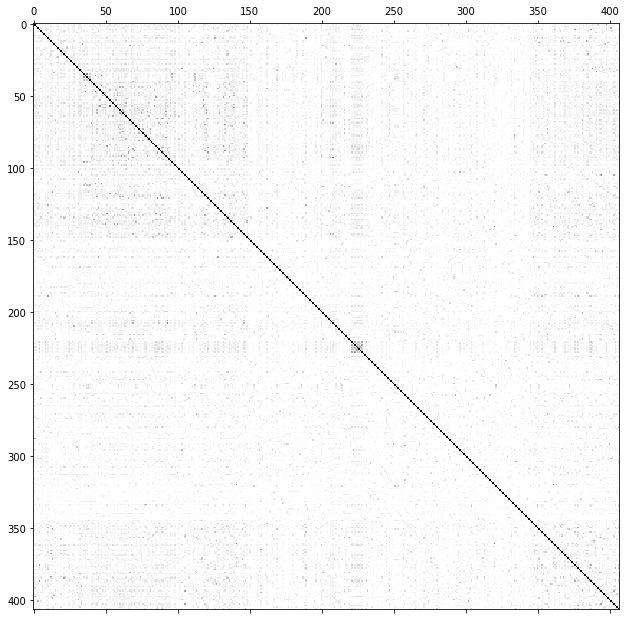

In [43]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [44]:
Ntop = 200
# Calculate the predictoins with Jaccard
predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[85.0, 51.0, 223.0, 228.0, 50.0, 132.0, 221.0,..."
1,1,"[85.0, 51.0, 223.0, 58.0, 132.0, 139.0, 50.0, ..."
2,2,"[51.0, 228.0, 223.0, 58.0, 132.0, 50.0, 139.0,..."
3,3,"[208.0, 227.0, 93.0, 206.0, 403.0, 13.0, 351.0..."
4,4,"[223.0, 133.0, 93.0, 221.0, 33.0, 391.0, 88.0,..."


In [45]:
topk = [5, 10, 20, 30]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

recall@5=0.242
recall@10=0.240
recall@20=0.361
recall@30=0.477


In [46]:
_ = m.map_at_n(topk)

map@5=0.406
map@10=0.313
map@20=0.323
map@30=0.344


In [47]:
# Memory Based in Collaborate Filter

In [48]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in train.values[:,0:5]:
    user = row[0]-1 #for use the same as index
    item = row[4]
    rating = row[1]
    uMatrixTraining[user, item] = rating

In [49]:
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:5]:
    # Note user ids start at 1
    user = row[0]-1
    item = row[4]
    rating = row[1]
    uMatrixTesting[user, item] = rating

In [50]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T)+epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings)+epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


USER - USER

In [51]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

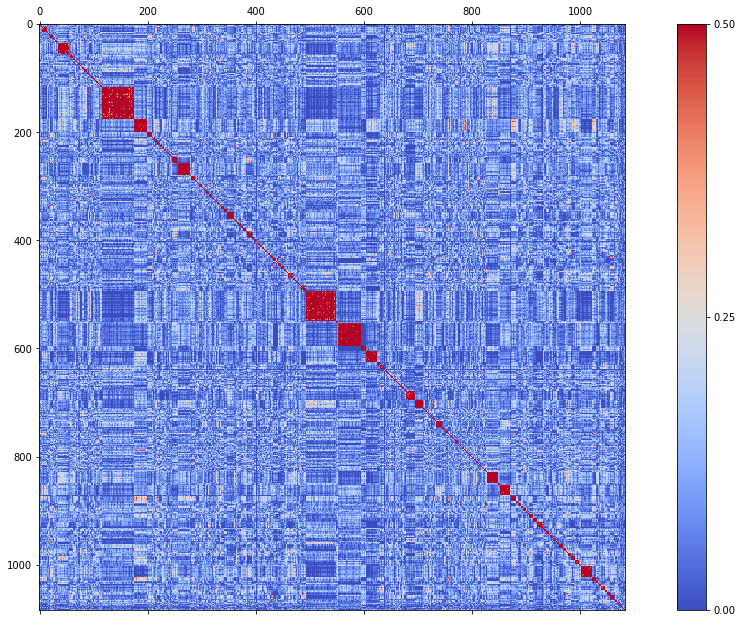

In [52]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [53]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

In [54]:
sum_ = uMatrixTraining.sum(axis=1)
len_ =np.count_nonzero(uMatrixTraining, axis=1)
average_ratings = np.tile(sum_/ len_, n_items).reshape([n_items, n_users]).T
uMatrixTraining_shifted = uMatrixTraining - np.multiply(average_ratings, uMatrixTraining)
userItemCFpredictions_corrected = average_ratings + userSimilarity.dot(uMatrixTraining_shifted) / norm

### Item-Item

In [55]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

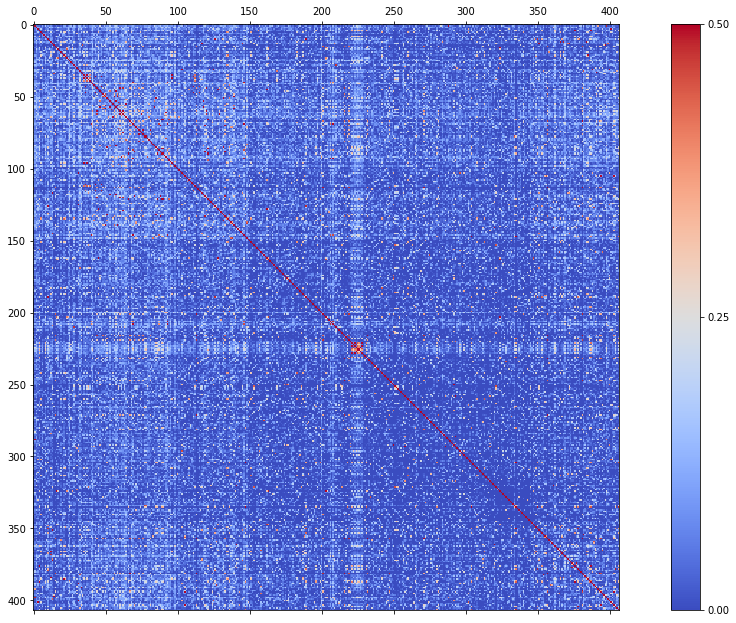

In [56]:
cax = plt.matshow(itemSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [57]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

In [58]:
query_Id = 300
print("Selected item is '%s'" % food_id[query_Id])


queryAnswer = np.argsort(itemSimilarity[query_Id,:])[::-1][1:]

Ntop = 10
print("Most %d similar movies are:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(food_id[answerId]+", with similarity %.2f" %itemSimilarity[query_Id, answerId])

Selected item is 'Raviolis rellenos de setas'
Most 10 similar movies are:
Arroz frito con curry, with similarity 0.24
Raviolis con salsa de nueces, with similarity 0.22
Puré de coliflor con queso, with similarity 0.17
Ternera asada con patatas nuevas, with similarity 0.17
Guisantes con huevo, with similarity 0.17
Tortilla de brócoli y queso, with similarity 0.17
Sushi sin alga nori, with similarity 0.15
Puré de Arvejas o Guisantes, with similarity 0.15
Pollo Empanado al Horno, with similarity 0.15
Pasta fresca casera, with similarity 0.15


In [59]:
itemItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 716
Items: 
['Ensalada de berenjenas árabe', 'Ensalada de Almendras y pollo', 'Secreto de cerdo a la plancha', 'Ternera a la jardinera', 'Salchichas en salsa de tomate', 'Salchichas Encebolladas', 'Estofado de Ternera con Verduras', 'Fusilli con atún y verduras', 'Raviolis rellenos de carne', 'Arroz amarillo con pollo', 'Revuelto de espinacas', 'Revuelto de berenjena']
Recommended items: 
['Secreto al horno', 'Ensalada con trigo americano y atún', 'Secreto de cerdo a la plancha', 'Patatas al vapor', 'Ensalada de Pasta con Macarrones', 'Estofado de ternera en salsa de tomate', 'Wok de pollo', 'Tortilla de patatas con espinacas', 'Pepinos al horno para guarnición', 'Espaguetis con pollo y curry']
******
User 1045
Items: 
['Ensalada de col con queso', 'Albóndigas de carne de res', 'Menestra de fréjol', 'Espinacas al Horno', 'Calabacines al horno con parmesano', 'Tortilla de calabacín con queso']
Recommended items: 
['Calabacines al horno con parmesano', 'Ensalada de garbanzos,

In [60]:
userItemCFpredictions[uMatrixTraining>=2.0] = 0.0
userItemCFpredictions_corrected[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])
    print("Recommended items (shifted version): ")
    recom = userItemCFpredictions_corrected[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 963
Seen items: 
['Acelgas con Patatas y Pimentón', 'Alambre de res con champiñones', 'Estofado de ternera al vino tinto', 'Pastel de acelga y patatas', 'Solomillo en salsa roquefort', 'Hamburguesa casera y fácil', 'Acelgas con patatas al vapor']
Recommended items: 
['Alambre de res con champiñones', 'Churrasco a la brasa', 'Estofado de ternera al vino tinto', 'Chuletas a la BBQ a la sartén', 'Guiso de ternera con garbanzos', 'Estofado de Ternera en Olla Express', 'Estofado de Ternera con Verduras', 'Redondo de Ternera con Setas', 'Chuletas de cerdo con salsa mostaza', 'Pastel de Carne']
Recommended items (shifted version): 
['Arroz Tres Delicias', 'Espaguetis Integrales con Salsa de Tomate Fresco', 'Rissoto de Quinoa', 'Espaguetis al horno', 'Arroz con alcachofas', 'Ensalada de arroz con judias verdes', 'Risotto de azafrán', 'Pizza con piña hawaiana', 'Macarrones con bechamel', 'Tallarines a la carbonara']
******
User 399
Seen items: 
['Chuletas de cordero asadas', 'Redond

In [61]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    """
    r, c = ground_truth.nonzero()
    p = prediction[r,c]
    t = ground_truth[r,c]
    return sqrt(np.mean(np.power(p-t, 2.0)))

In [62]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

User-based CF RMSE=2.789


In [63]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

Item-based CF RMSE=2.815


In [64]:
itemItemCFpredictions_sorted = np.argsort(itemItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: itemItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)



*****Recall*****
recall@5=0.402
recall@10=0.391
recall@20=0.497
recall@50=0.670
recall@100=0.808
*****Map*****
map@5=0.467
map@10=0.397
map@20=0.402
map@50=0.433
map@100=0.448


In [65]:
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)


*****Recall*****
recall@5=0.341
recall@10=0.307
recall@20=0.412
recall@50=0.599
recall@100=0.736
*****Map*****
map@5=0.298
map@10=0.240
map@20=0.256
map@50=0.291
map@100=0.305


In [66]:
#GRAFOS